# Human Study Results

## Import libraries and set up plot parameters

In [1]:
import pandas as pd
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.plotting_utils import cumulative_reward_per_game
from src.bandits import lipschitz_best_arm

sns.set_palette("colorblind")
legend_font_size = 20
marker_size_main = 4
marker_size_hat = 20
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 35,
    "figure.figsize":(15,9)
})

## Read study data 

In [2]:
study_data_path = '../human_study_data/study_data.csv'
study_data = pd.read_csv(study_data_path)

## Average discounted cumulative reward per $\varepsilon$ value 

In [3]:
# set discount factor
gamma = 0.99
unique_game_key_list = ['mapId', 'initLocId', 'seed', 'epsilon']
study_data['discounted_reward'] = study_data[['reward', 'time_step']].apply(lambda x: int(x['reward']) * (np.round(gamma, decimals=2) ** int(x['time_step'])), axis=1)
discounted_cumulative_rewards = study_data.groupby(unique_game_key_list).agg({'discounted_reward': 'sum'}).rename(columns={'discounted_reward': 'reward'}).reset_index()


In [4]:
base_path_dqn = lambda t,p :f'../outputs/rewards/10x10/from_file/sigma_0.01/hum_greedy/{t}_{p}/machine_{t}_{p}/arm_1.0/rewards.pkl'
agent_type = 'dqn'
agent_params = [1]
scaled = False
df_dqn = cumulative_reward_per_game(base_path_dqn, agent_type, agent_params, gamma=gamma)

### Average Discounted Cumulative Reward 

In [5]:

# create teh coarse grained bins of epsilon values 
step = 5

discounted_cumulative_rewards_binned = discounted_cumulative_rewards.reset_index()
discounted_cumulative_rewards_binned['epsilon'] = discounted_cumulative_rewards_binned['epsilon'].apply(lambda x: np.round(x * 100/step) / (100/step))
discounted_cumulative_rewards_binned.loc[discounted_cumulative_rewards_binned['epsilon'] > 0.3, 'epsilon'] = discounted_cumulative_rewards.reset_index().loc[discounted_cumulative_rewards.reset_index()['epsilon'] > 0.3, 'epsilon']




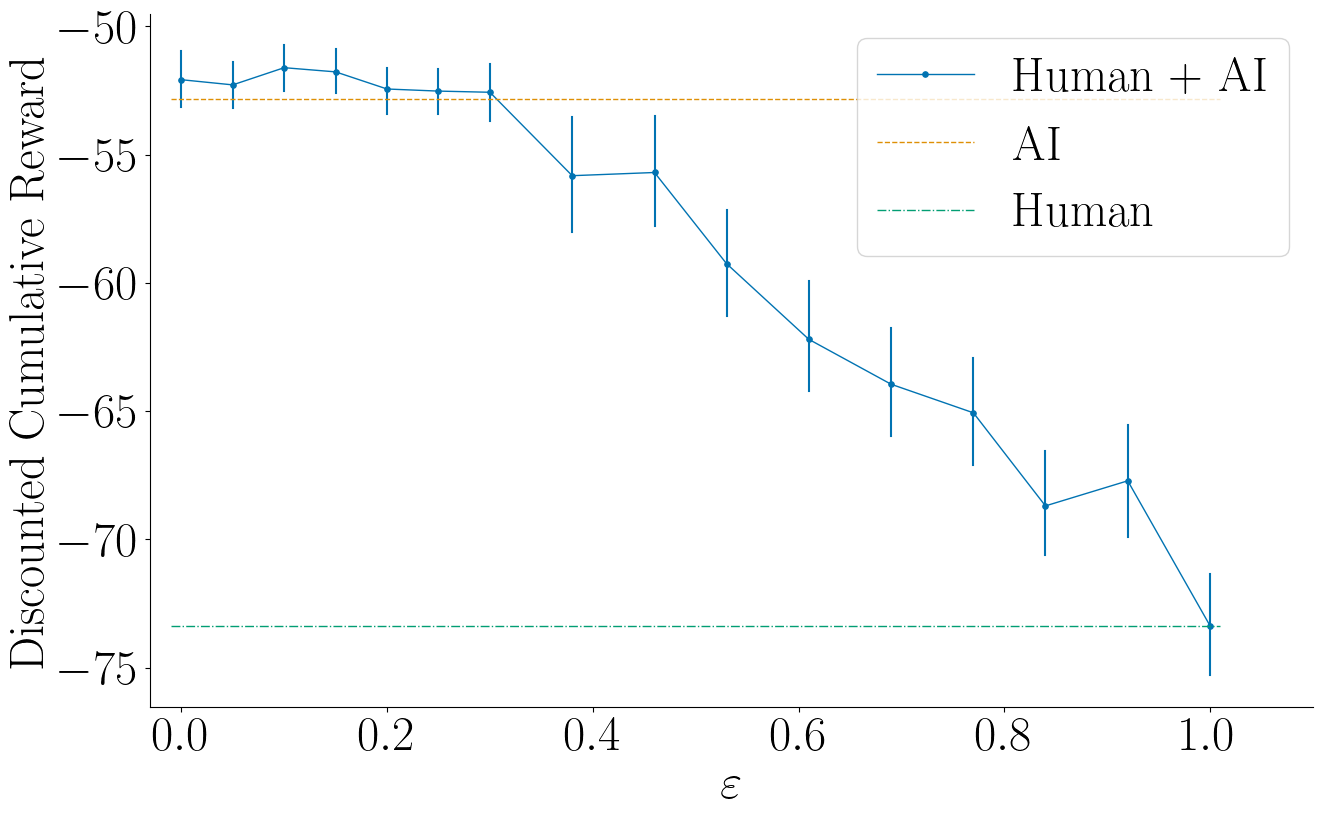

In [6]:

# average discounted cumulative reward per epsilon bin
ax1 = sns.lineplot(data=discounted_cumulative_rewards_binned, x='epsilon', y='reward', errorbar=('ci', 95), err_style='bars', marker='o', linewidth=1, markeredgecolor=None, markersize=marker_size_main, label=r'Human + AI')

# DQN average discounted cumulative reward
plt.hlines(y=df_dqn['cumulative_reward'].mean(), xmin=-0.01, xmax=1.01, linestyles='dashed', linewidth=1, label=r'AI', colors=sns.color_palette('colorblind')[1])

# human alone discounted cumulative reward
human = discounted_cumulative_rewards.reset_index()[discounted_cumulative_rewards.reset_index()['epsilon'] == 1.0]
_ = plt.hlines(y=human.reward.mean(), xmin=-0.01, xmax=1.01, linestyles='-.', linewidth=1, label=r'Human',  colors=sns.color_palette('colorblind')[2])

plt.legend(loc='best')
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'Discounted Cumulative Reward')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
_ = plt.xlim(-0.03,1.1)


### Cumulative Discounted Reward Distribution

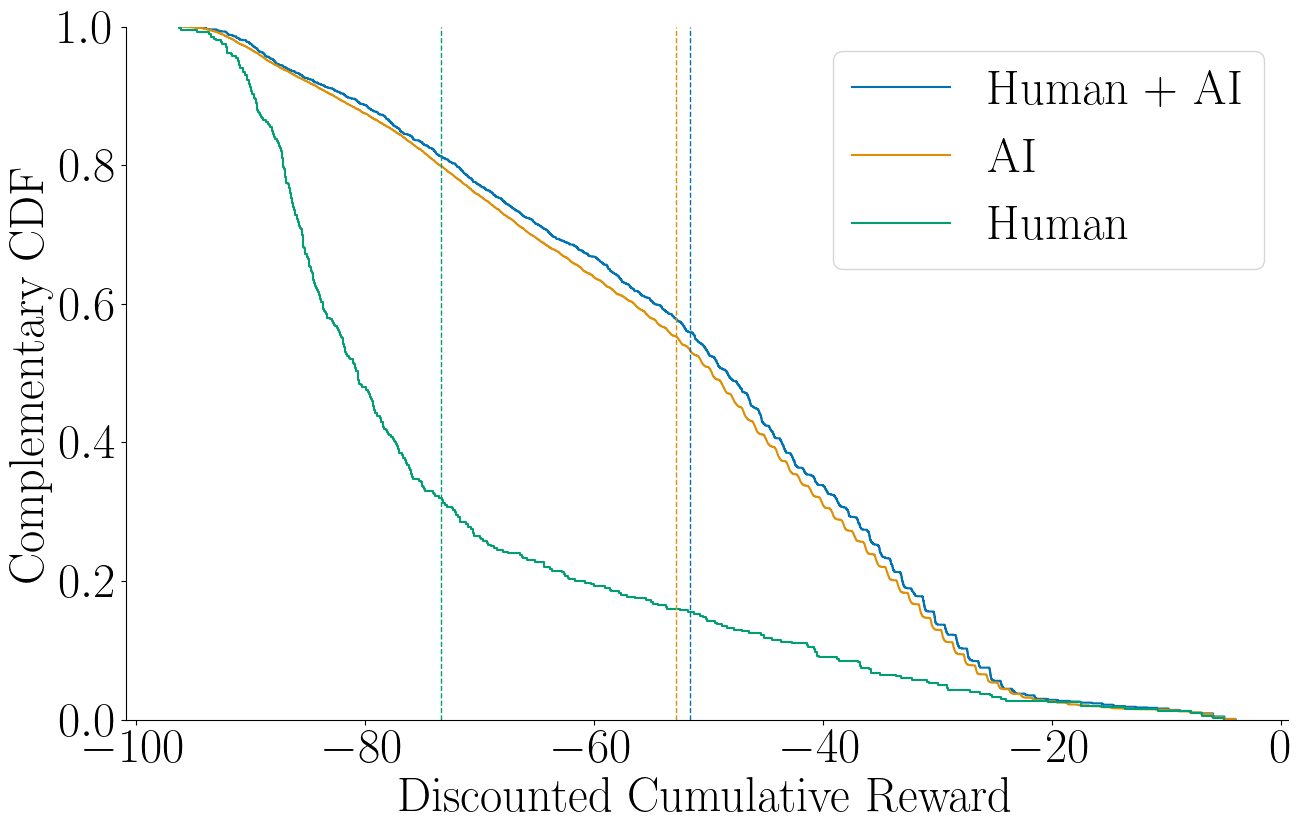

In [7]:
# distribution of cumulative discounted rewards of optimal epsilon bin against DQN and human alone

rewards_optimal_bin = discounted_cumulative_rewards_binned.reset_index()[(discounted_cumulative_rewards_binned.reset_index()['epsilon'] == 0.1)]
human = discounted_cumulative_rewards_binned.reset_index()[(discounted_cumulative_rewards_binned.reset_index()['epsilon'] == 1.0)]
# complementary CDF plots
_ = sns.ecdfplot(data=rewards_optimal_bin, x='reward',  label=r'Human + AI',  stat="proportion",  complementary=True)
ax = sns.ecdfplot(data=df_dqn, x='cumulative_reward',  label=r'AI',  stat="proportion",   complementary=True)
_ = sns.ecdfplot(data=human, x='reward',  label='Human',  stat="proportion",   complementary=True)
plt.legend()

# add the mean of each distribution as a vertical line
plt.vlines(x = df_dqn['cumulative_reward'].mean(), ymin=0, ymax=1.0, colors=sns.color_palette('colorblind')[1], linestyles='dashed', label='DQN Mean', linewidth=1)
plt.vlines(x = discounted_cumulative_rewards_binned[discounted_cumulative_rewards_binned['epsilon'] == 0.1]['reward'].mean(), ymin=0, ymax=1.0, colors=sns.color_palette('colorblind')[0], linestyles='dashed', label='Optimal Epsilon Mean', linewidth=1)
plt.vlines(x = human['reward'].mean(), ymin=0, ymax=1.0, colors=sns.color_palette('colorblind')[2], linestyles='dashed', label='Human', linewidth=1)

plt.ylabel(r'Complementary CDF')
plt.xlabel(r'Discounted Cumulative Reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



### Maximum Improvement Achieved by the Best Decision Support Policies

In [8]:
human_mean = human['reward'].mean()
dqn_mean = df_dqn['cumulative_reward'].mean()
optimal_mean = discounted_cumulative_rewards_binned[discounted_cumulative_rewards_binned['epsilon'] == 0.1]['reward'].mean()

print(f"Human mean: {human_mean}, DQN mean: {dqn_mean}, Optimal epsilon mean: {optimal_mean}")
print(f"Human + optimal improvement over human: {((optimal_mean - human_mean) / abs(human_mean)) * 100:.2f}%")
print(f"Human + optimal improvement over DQN: {((optimal_mean - dqn_mean) / abs(dqn_mean)) * 100:.2f}%")

Human mean: -73.36477690184671, DQN mean: -52.835100993234384, Optimal epsilon mean: -51.613386632431286
Human + optimal improvement over human: 29.65%
Human + optimal improvement over DQN: 2.31%


### T-test for the discounted cumulative reward distributions 

In [9]:
# compare the reward distributions under the epsilon values of the optimal bin against the distribution of rewards achieved by humans alone
tstat, pvalue1 = ttest_ind(rewards_optimal_bin['reward'], human['reward'], equal_var=False)
# compare the reward distributions under the epsilon values of the optimal bin against the distribution of rewards achieved by DQN
tstat, pvalue2 = ttest_ind(rewards_optimal_bin['reward'], df_dqn['cumulative_reward'], equal_var=False)
pvalue1, pvalue2

(np.float64(3.653127555920979e-69), np.float64(0.011604866696460304))

## Lipschitz Best Arm Identification Algorithm

### Simple Regret

In [10]:
# compute the simple regret of the bandit algorithms
L = 150.0
b = 2
n = 100
res_df = pd.read_csv(f"../outputs/bandits/liba_vs_unif_results_L{L}_b{b}_n{n}.csv")
res_conf = res_df
res_conf['Alg'] = res_conf['Alg'].map(lambda x: 'Algorithm 1 (Ours)' if x == 'Ours' else 'Algorithm 2 (Uniform)')
reward = discounted_cumulative_rewards.reset_index().groupby('epsilon').agg({'reward':'mean'})

eps_opt = reward['reward'].idxmax()
max_reward = reward['reward'].max()
res_conf.loc[:, 'payoff'] = reward.loc[res_conf['eps_opt'], 'reward'].values
res_conf.loc[:, 'regret'] = max_reward - res_conf['payoff']

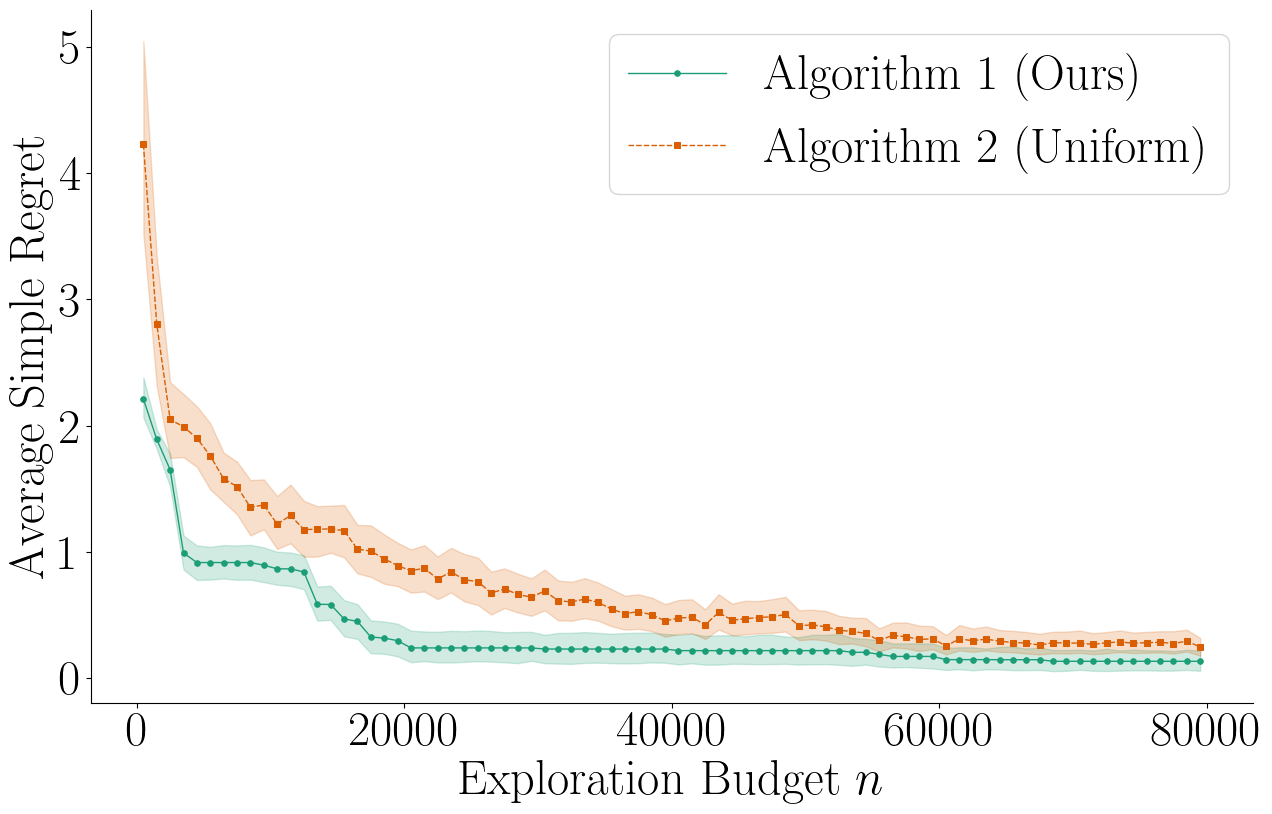

In [11]:
sns.set_palette("Dark2")
ax= sns.lineplot(data=res_conf, x='n', y='regret',  style='Alg', hue='Alg', markers={'Algorithm 1 (Ours)':'o', 'Algorithm 2 (Uniform)':'s'}, errorbar=('ci', 95), markeredgecolor=None, markersize=marker_size_main, linewidth=1)

plt.legend(title='', )
plt.xlabel(r'Exploration Budget $n$')
plt.ylabel(r'Average Simple Regret')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Plot the arm intervals and optimal arm discovered by the lipschitz best arm identification algorithm 

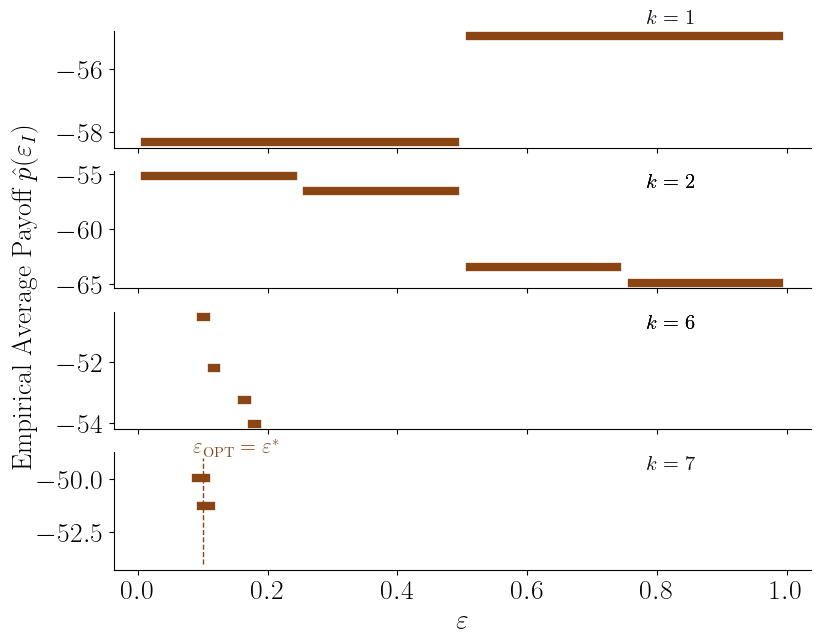

In [12]:
legend_font_size = 25
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 20,
    "figure.figsize":(15,9)
})
# identify one nice example of the algorithm execution
rng = np.random.default_rng(2083202570)
beta = 2
L = 150 
n = 30000
cumu_reward_episode_per_arm = discounted_cumulative_rewards.set_index(['epsilon'])
random_states = rng.integers(0, 2**32 - 1, size=1000)
for r in random_states:
    eps_opt, max_payoff, intervals = lipschitz_best_arm(cumu_reward_episode_per_arm, lipschitz_const=L, beta=beta, n=n, eps_max=1.0, random_state=r, return_intervals=True)
    if int(eps_opt * 100) == 10:
        if intervals.groupby('iteration').count().loc[intervals['iteration'].max()].values[0] <= 4:
            break

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(9,7))
# show the first and last two iterations
for i in range(4):
    ax = axs[i]
    if i > 1:
        i = i + intervals['iteration'].max() - 4
    df = intervals[intervals['iteration'] == i + 1]
    
    eps = 1.14e-2
    for i, row in df.iterrows():
        ax.plot([row['interval_start']+eps, row['interval_end']-eps], [row['empirical_payoff'], row['empirical_payoff']], color='saddlebrown', linewidth=6)
        if row['iteration'] == 1:
            ax.annotate(f"{r'$k=$'} {int(row['iteration'])}", xy=(0.8, 1.1), xycoords='axes fraction', ha='center', va='center', fontsize=15, color='black', alpha=0.7)
        else:
            ax.annotate(f"{r'$k=$'} {int(row['iteration'])}", xy=(0.8, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=15, color='black', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.xlabel(r'$\varepsilon$')
fig.text(0.01, 0.5, r'Empirical Average Payoff $\hat{p}(\varepsilon_{I})$', rotation='vertical', va='center', )
axs[3].vlines(x=eps_opt, ymin=-54, ymax=-49, colors='saddlebrown', linestyles='dashed', label=r'$\varepsilon^{*}$', linewidth=1)
_ = axs[3].annotate(r'$\varepsilon_{\text{OPT}} = \varepsilon^{*}$', xy=(eps_opt, -51), xytext=(eps_opt*0.85, -48.8), fontsize=15, color='saddlebrown')